In [9]:
import numpy as np
from gaussian_process import GaussianProcess, matern52_kernel
from bayes_opt import BayesianOptimisation, expected_improvement
from samplers import gaussian_sampling
from objectives import log_likelihood
import matplotlib.pyplot as plt
from parameter_estimation import estimate_params
from lensmodel import mean_function_theta


def read_and_convert(file_name, I_0, f_s):
    """
    This function reads a file for microlens event (.dat) and converts the magnitude to magnification.
    -------------------------
    Parameters:
    file_name (str): The name of the file to read.
    I_0 (float): The reference magnitude. (can be found in the data webpage and zip file)
    -------------------------
    Returns:
    data (DataFrame): The data read from the file with an additional column for magnification.
    """
    data = np.loadtxt(file_name)
    times = data[:, 0]
    magnitudes = data[:, 1]
    mag_errors = data[:, 2]
    delta_I = magnitudes - I_0
    magnifications = ((10 ** (delta_I / -2.5) - 1) / f_s) + 1
    magnification_errors = magnifications * np.log(10) * (mag_errors / 2.5)
    # magnifications += 1 - np.min(magnifications)

    # mag_peak = np.max(magnifications)
    # threshold = 1 + (mag_peak - 1) * 0.0
    # mask = magnifications > threshold
    # magnifications = magnifications[mask]
    # times = times[mask]
    # magnification_errors = magnification_errors[mask]

    return times, magnifications, magnification_errors


def plot_final_params(observed_times, magnifications, best_parameters, mags_error=None):
    """
    Plot the predicted magnification function and the observed data.
    Args:
        observed_times (ndarray): Times observed.
        magnifications (ndarray): Magnifications observed.
        best_parameters (list): Parameters being plotted.
        mags_error (ndarray): Errors on the observed magnifications.

    """
    # Create fine mesh of times from the first observation to the last observation
    times = np.linspace(np.min(observed_times), np.max(observed_times), 10000)

    # Calculate predicted magnifications
    theta = [best_parameters[0], best_parameters[2]]
    mags = mean_function_theta(times, theta, best_parameters[1])

    # Plot prediction with the observed data
    plt.plot(times, mags, color="blue")
    if mags_error is not None:
        plt.errorbar(observed_times, magnifications, mags_error, fmt=".", color="red")
    else:
        plt.scatter(observed_times, magnifications, color="red")
    plt.savefig(
        f"BO_plot/final_params{best_parameters[0]}_{best_parameters[1]}_{best_parameters[2]}.png"
    )
    plt.show()

Initial predictions:
    t_0: 2459997.9897364737 ± 1.2175910275108308
    u_min: 0.10802778494371172 ± 0.007477034710907043
    t_E: 168.88381384164552 ± 68.10043910206582


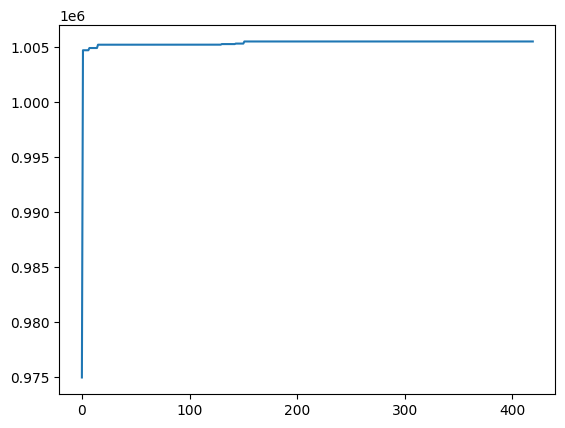

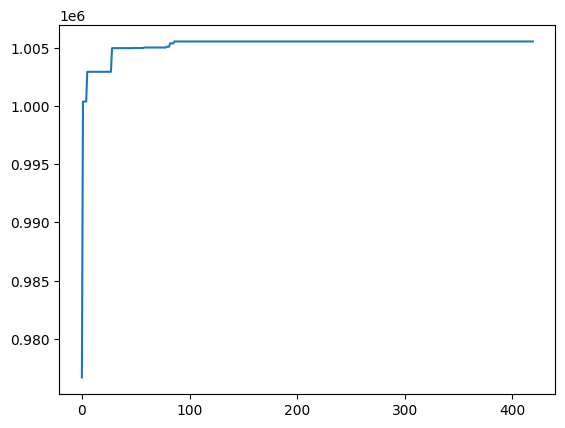

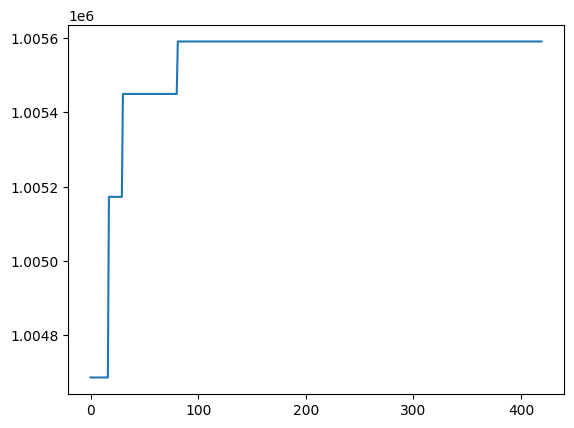

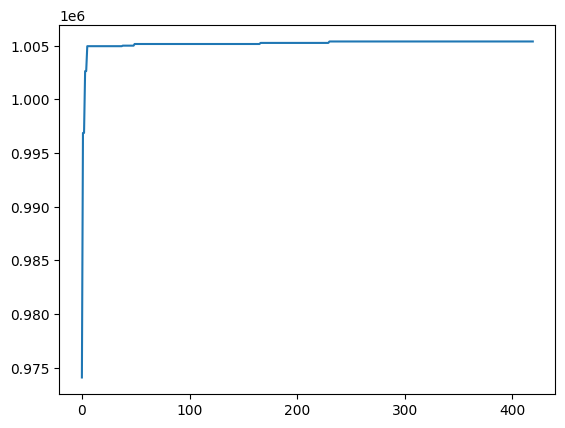

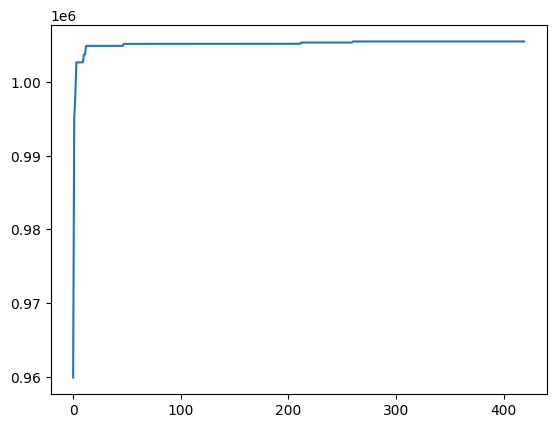

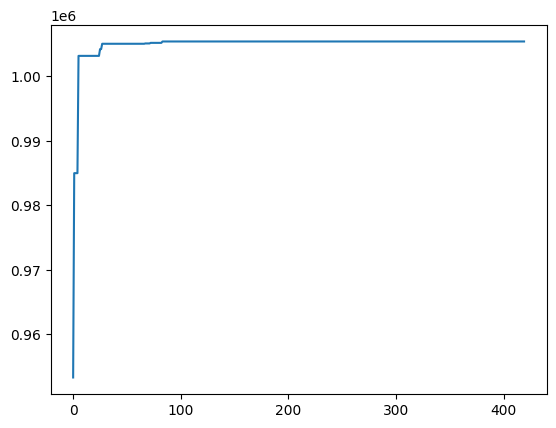

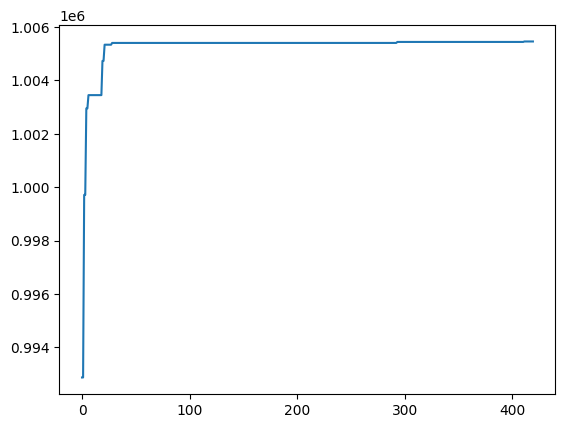

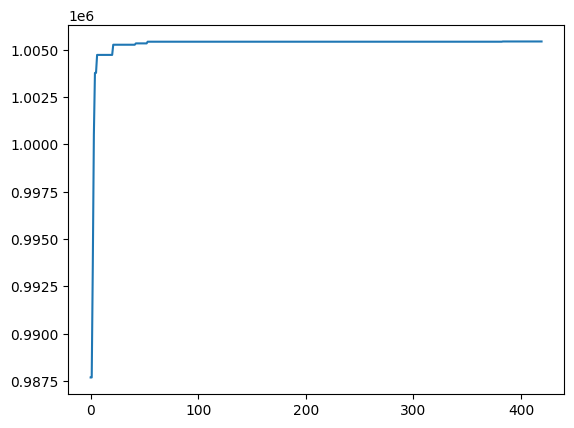

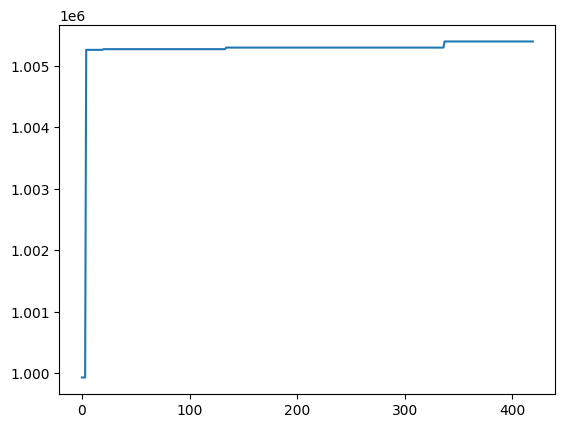

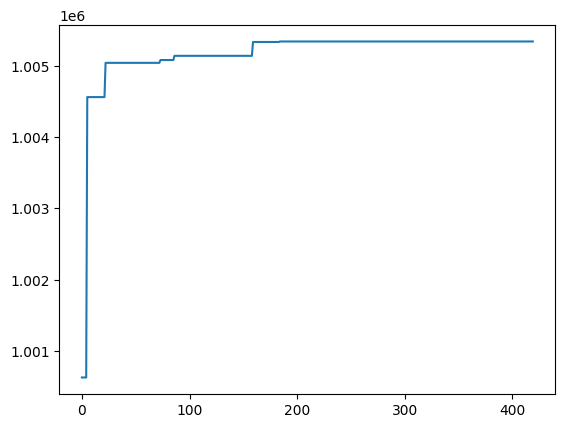

Final predictions:
    t_0: 2459995.684349311 ± 0.9207677090131883
    u_min: 0.113942754331672 ± 0.003814825713119234
    t_E: 103.22589367735448 ± 4.821402886594009


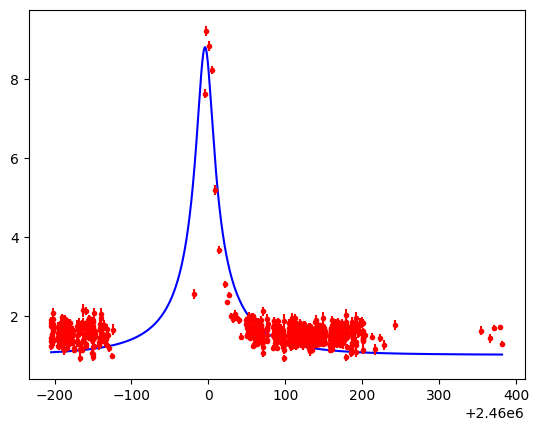

In [10]:
I_0 = 19.956 - 0.361 * 2
f_s = 0.528
time, mags, mags_error = read_and_convert(
    "sample_data_OGLE/OGLE-2023-BLG-0002.dat", I_0, f_s
)

observed_times = time
magnifications = mags
magnification_errors = mags_error

parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}

bounds = parameter_bounds

mean_function = None
sigma = 1

# Change bounds on t_0 before estimating
bounds["t_0"] = [np.min(observed_times), np.max(observed_times)]

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=1, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)

plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)